In [1]:
"""
author: gowthamkuntumalla

Title: Quantitative Analysis of Stock Prices for Similarity Grouping using Technical Indicator

# Quantitative Analysis: https://www.investopedia.com/terms/q/quantitativeanalysis.asp
# Technical Indicator: https://www.investopedia.com/terms/t/technicalindicator.asp

Statistical Learning Techniques are employed for clustering and such.
"""

import pandas as pd
import numpy as np
idx = pd.IndexSlice
from pathlib import Path

#plotting
import matplotlib.pyplot as plt

# Features

There are two basic types of technical indicators:

**Overlays**: Technical indicators that use the same scale as prices are plotted over the top of the prices on a stock chart. Examples include moving averages and Bollinger Bands. <br>
**Oscillators**: Technical indicators that oscillate between a local minimum and maximum are plotted above or below a price chart. Examples include the stochastic oscillator, MACD or RSI.

## 1. Bollinger Bandwidth

In [2]:
def bollinger_bandwidth(m = 2, n = 20,col_name = 'bollinger_bandwidth'):
    """  
    Bollinger Bandwidth 
    
    https://www.investopedia.com/terms/b/bollingerbands.asp
    
    """
    # Bollinger Bandwidth = ((Upper Band - Lower Band) / Middle Band) * 100 
    # m = num of standard devs (typically 2)
    # n = No. days in smoothening period (typically 20)
    
    
    def MA(tp,n):
        """Moving Average"""
        return tp.rolling(n).mean()
    
    def TP(stock):
        """Typical Price"""
        return (stock['high']+stock['low']+stock['close'])/3 
    
    def stdev(tp,n):
        return tp.rolling(n).std()
        
    for tick in tickers: 
        stock = stocks_df.loc[tick]
        stock_tp = TP(stock)
        middle_band = MA(stock_tp,n) # Middle Bollinger Band
        a = 2*m*stdev(stock_tp,n)/ middle_band 
        a.rename(None,inplace=True)
        stocks_df.loc[tick,col_name] = pd.DataFrame(a,columns = [col_name])

## 2. Coppock Curve

In [3]:
def coppock_curve(m = 10, n1= 14, n2 = 11, price_type = 'close',col_name = 'coppock_curve'):    
    """ 
    Coppock Curve
    
    https://www.investopedia.com/terms/c/coppockcurve.asp
    
    Using default price columns as 'close'
    """
    # 10-period WMA of (14-period RoC + 11-period RoC)
    # ROC = [(Close - Close n periods ago) / (Close n periods ago)] * 100 
    
    def RoC(stock_price,n): 
        """Rate of change"""
        return 100*stock[price_type].pct_change(periods = n)
        
    
    def WMA(m,roc_n1,roc_n2):
        """Weighted Moving Average"""  
        weights = np.arange(1,m+1) #this creates an array with integers 1 to 10 included
        return (roc_n1 + roc_n2).rolling(m).apply(lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)
    
    for tick in tickers: 
        stock = stocks_df.loc[tick]
        
        roc_n1 = RoC(stock,n1)
        roc_n2 = RoC(stock,n2)
        
        a = np.round(WMA(m,roc_n1,roc_n2),decimals = 3)/1.0
        a.rename(None,inplace=True)
        stocks_df.loc[tick,col_name] = pd.DataFrame(a,columns = [col_name])
        
    

## 3. Correlation Coefficient

In [4]:
def corr_coef():
    """
    Correlation Coefficient
    
    """
    
    pass

## 4. MACD

In [5]:
def macd(nfast = 12 , nslow =26 ,m = 9,price_type = 'close',col_name = 'macd'):
    """
    Moving Average Convergence Divergence
    
    https://www.investopedia.com/terms/m/macd.asp
    
    Note: difference between macd and signal is stored for convenience
    """
    # macd = 12-Period EMA − 26-Period EMA
    # signal = 9 period ema of macd
    
    for tick in tickers: 
        stock = stocks_df.loc[tick]
        
        macd = stock[price_type].ewm(span = nfast).mean()-stock[price_type].ewm(span = nslow).mean()
        signal = macd.ewm(span = m).mean()
        a = np.round(macd - signal,5)
        a.rename(None,inplace=True)
        stocks_df.loc[tick,col_name] = pd.DataFrame(a,columns = [col_name])
        

## 5. Market Facilitation Index

In [6]:
def market_fac_ind(col_name = 'market_fac_ind'):
    """
    Market Facilitation Index
    
    https://en.wikipedia.org/wiki/Market_facilitation_index
    https://www.tradingview.com/script/trUemla9-Market-Facilitation-Index-MFI/
    
    Use the indicator to see if the market is trending
    """
    # (High - Low) / Volume
    for tick in tickers: 
        stock = stocks_df.loc[tick]
        a = (stock['high'] - stock['low'])/stock['volume']
        a.rename(None,inplace=True)
        stocks_df.loc[tick,col_name] = pd.DataFrame(a,columns = [col_name])
        
    
    

## 6. Momentum Indicator

In [7]:
def momentum_indic(n = 14,col_name = 'momentum_indic', price_type = 'close'):
    """
    Momentum Indicator
    
    https://commodity.com/technical-analysis/momentum/
    
    """
    # (Price today - Price n periods ago) x 100
    
    for tick in tickers: 
        stock = stocks_df.loc[tick]
        
        a = stock[price_type] - stock[price_type].shift(periods = n)
        
        a.rename(None,inplace=True)
        stocks_df.loc[tick,col_name] = pd.DataFrame(a,columns = [col_name])
        

## 7. Positive Volume Index

In [8]:
def pvi(col_name = 'pvi', price_type = 'close', ppvi = 100):
    """
    Positive Volume Index
    
    https://www.investopedia.com/terms/p/pvi.asp
    
    Implementation is slow. It may be improved!
    """
    # pvi = ppvi + (tcp-ycp)/ycp * ppvi
    # if tvol < yvol :then pvi = ppvi
    # if no starting value :then ppvi  = 100 # starting value arbritrary
    
    def func(stock,ppvi):
        a = pd.Series(stock.index)       
        a.iloc[0] = ppvi        
        for i in range(1, len(a)):            
            if stock['volume'].iloc[i] > stock['volume'].iloc[i-1]:
                pvi = ppvi * (1+ (stock[price_type].iloc[i]-stock[price_type].iloc[i-1])/stock[price_type].iloc[i-1])
                a.iloc[i] = pvi
                ppvi = pvi
            else:
                a.iloc[i] = ppvi
        return a
    
    for tick in tickers: 
        stock = stocks_df.loc[tick]
        a = func(stock,ppvi)
        a.rename(None,inplace=True)
        stocks_df.loc[tick,col_name] = pd.DataFrame(a,columns = [col_name])
        
    stocks_df[col_name] = stocks_df[col_name].astype('float64')


## 8. Relative Volatility Index

In [9]:
def rvi(n = 10, m = 14,col_name = 'rvi'):
    """
    Relative Volatility Index
    
    https://user42.tuxfamily.org/chart/manual/Relative-Volatility-Index.html
    
    """
    # n = stdev periods
    # m = EMA periods
    
    def func(stock,n,m,price_type):       
        stdev = stock[price_type].rolling(n).std()
        mask = stock[price_type] > stock[price_type].shift(periods = 1)
        
        numer = stdev.where(mask,other = 0).ewm(span = m, min_periods=m,adjust=False).mean()
        denom = stdev.ewm(span = m, min_periods=m,adjust=False).mean()
        
        rviOrig =   100 * (numer)/(denom)        
        return rviOrig
        
    for tick in tickers: 
        stock = stocks_df.loc[tick]
        
        a = np.round(0.5*(func(stock,n,m,'high') + func(stock,n,m,'low')),3)

        a.rename(None,inplace=True)
        stocks_df.loc[tick,col_name] = pd.DataFrame(a,columns = [col_name])


## 9. Standard Deviation

In [10]:
def st_dev(n = 10,col_name = 'st_dev'):
    """
    Standard Deviation
    
    """
    # n = no of days to calculate standard deviation

    def TP(stock):
        """Typical Price"""
        return (stock['high']+stock['low']+stock['close'])/3 
    
    def stdev(tp,n):
        """rolling standard deviation"""
        return tp.rolling(n).std()
    
    for tick in tickers: 
        stock = stocks_df.loc[tick]
        stock_tp = TP(stock)
        a = stdev(stock_tp,n)
        a.rename(None,inplace=True)
        stocks_df.loc[tick,col_name] = pd.DataFrame(a,columns = [col_name])
    

## 10. Stochastic Momentum Index

In [11]:
def smi(col_name = 'smi',n = 14, m = 3):
    """
    Stochastic Momentum Index
    
    https://www.fmlabs.com/reference/default.htm?url=SMI.htm
    https://tradingqna.com/t/need-formula-for-stochastic-momentum-index-indicator/43201
    """
    # n = period 1 for calculating centre
    # m = period 2 for EMA
    
    def func(stock,n,m):
        centre = 0.5 * (stock['high'].rolling(n).max() + stock['low'].rolling(n).min()) 
        H = stock['close'] - centre        
        cm = H.ewm(span = m).mean().ewm(span = m).mean()
        
        HL = stock['high'].rolling(n).max() - stock['low'].rolling(n).min()
        hl = HL.ewm(span = m).mean().ewm(span = m).mean()
        
        SMI = 100 * cm/(hl/2)
        return SMI
        
    
    for tick in tickers: 
        stock = stocks_df.loc[tick]
        a = np.round(func(stock, n,m),3)
        a.rename(None,inplace=True)
        stocks_df.loc[tick,col_name] = pd.DataFrame(a,columns = [col_name])
    


## 11. Stochastics

In [12]:
def stochastics(col_name = 'stochastics', n = 14,price_type = 'close'):
    """
    Stochastics (Stochastic Oscillator)
    
    https://www.investopedia.com/terms/s/stochasticoscillator.asp
    
    """
    # %K=(C- H14)/(H14−L14)×100
    
     
    for tick in tickers: 
        stock = stocks_df.loc[tick]
        
        a = 100 * (stock[price_type] - stock[price_type].rolling(n).min())\
                    /(stock[price_type].rolling(n).max() - stock[price_type].rolling(n).min())
        
        a.rename(None,inplace=True)
        stocks_df.loc[tick,col_name] = pd.DataFrame(a,columns = [col_name])
    

## 12. Typical Price

In [13]:
def typical_price(col_name= 'typical_price'):
    """
    Typical Price
    
    https://en.wikipedia.org/wiki/Typical_price
    
    """    
    # H+L+C/3
    for tick in tickers:
        stock = stocks_df.loc[tick]
        a = (stock['high']+stock['low']+stock['close'])/3     
        a.rename(None,inplace=True)
        stocks_df.loc[tick,col_name] = pd.DataFrame(a,columns = [col_name])
        

# Import Data

In [35]:
dirname = 'sandp500'
csv_file = 'all_stocks_5yr.csv'
filename = Path(dirname, csv_file)
stocks_df = pd.read_csv(filename)
stocks_df['date'] = pd.to_datetime(stocks_df['date'],format='%m/%d/%Y')
stocks_df.set_index(['Name','date'],inplace = True) # contains all stocks time series data
stocks_df.head()
imported_data = stocks_df

# Calling Features

In [36]:
import time
## Names of all feature functions
feature_funcs = [bollinger_bandwidth,coppock_curve,corr_coef,macd,\
                 market_fac_ind,momentum_indic,pvi,rvi,st_dev,smi,stochastics,typical_price]

## Stock Tickers. Ex: 'AAPL', 'MSFT' ...
tickers = stocks_df.index.get_level_values(0).unique().tolist() # len(tickers) == 505

for func in feature_funcs:
    start_t = time.perf_counter()
    func()
    end_t = time.perf_counter()
    print('Time to run {0} func = {1} sec'.format(str(func),end_t-start_t))

    """Note:
    1. Corr_coeff does nothing here
    2. pvi is slow, others are pretty quick
    3. It may take 5 min to run all functions
    4. There are 11 feature columns in addition to the original 5 data columns""" 

In [47]:
""" Adding more features from another IPYNB file"""

more_features = pd.read_csv('Akhilesh_Feature_Generation.csv') # run project_AS.ipynb
more_features['date'] = pd.to_datetime(more_features['date'],format='%Y/%m/%d')
more_features.set_index(['Name','date'],inplace = True)
all_features_df = pd.concat([stocks_df,more_features.iloc[:,5:]], axis = 1)
print(all_features_df.head())
all_features_df.to_csv('All_features_df.csv')

                  open   high    low  close    volume  bollinger_bandwidth  \
Name date                                                                    
AAL  2013-02-08  15.07  15.12  14.63  14.75   8407500                  NaN   
     2013-02-11  14.89  15.01  14.26  14.46   8882000                  NaN   
     2013-02-12  14.45  14.51  14.10  14.27   8126000                  NaN   
     2013-02-13  14.30  14.94  14.25  14.66  10259500                  NaN   
     2013-02-14  14.94  14.96  13.16  13.99  31879900                  NaN   

                 coppock_curve     macd  market_fac_ind  momentum_indic  ...  \
Name date                                                                ...   
AAL  2013-02-08            NaN  0.00000    5.828130e-08             NaN  ...   
     2013-02-11            NaN -0.00289    8.444044e-08             NaN  ...   
     2013-02-12            NaN -0.00624    5.045533e-08             NaN  ...   
     2013-02-13            NaN  0.00311    6.725474e-

# Prediction Modelling (in progess)

## PCA

In [17]:
from sklearn.decomposition import PCA
# linear transformation

NMF (similar to PCA) Non negative Feature Factorization: Not useful here as it requires non - negative features.

## Pipeline: Standard Scaler + KMeans

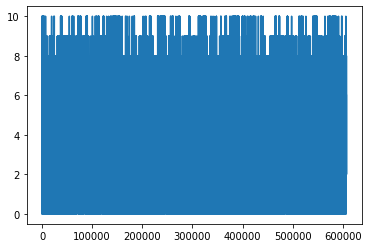

[4 4 4 ... 6 6 6]
Empty DataFrame
Columns: []
Index: []


In [18]:
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline


#n_clusters = elbow of KMeans.interia_ plot n),  industries ~ 11
stocks_df.dropna(inplace = True)
 
kmeans_pipeline = Pipeline(steps = [('stsc',StandardScaler()),('clf',KMeans(n_clusters = 11))]) #('norm', Normalizer())
kmeans_pipeline.fit(stocks_df)
labels = kmeans_pipeline.predict(stocks_df)
stocks_df.describe()
plt.plot(labels)
plt.show()
print(labels)

# Cross Tabulation to see effectiveness of split
df_res = pd.DataFrame({'labels': labels,'companies': stocks_df.index})
res = pd.crosstab(df_res['labels'], df_res['companies'])
print(res)

# Another trial
# df = stored_df.reset_index().pivot(index = 'date', columns='Name')
# df.columns = df.columns.swaplevel(0, 1)
# df.sort_index(axis=1, level=0, inplace=True)
# df

## Visulization: t-SNE (very slow- halted)

In [19]:
# from sklearn.manifold import TSNE
# tsne = TSNE(learning_rate = 100) # change learning rate from 50 to 200. good --> not all are bunched together

# tsne_features = tsne.fit_transform(stocks_df)

# xs = tsne_features[:,0]
# ys = tsne_features[:,1]
# plt.scatter(xs,ys)
# plt.show()